# Imports

In [1]:
import csv
import json
import random
import re
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

import torch

from datasets import (
    Dataset,
    DatasetDict,
    concatenate_datasets,
    load_dataset,
    load_from_disk,
)
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)

import evaluate

from nameparser import HumanName
from names_dataset import NameDataset, NameWrapper
from ethnicseer import EthnicClassifier
import nltk
from nltk.corpus import wordnet as wn

import pycountry_convert as pc
import pycountry
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score

# Load GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Loading data

## Base Data

In [ ]:
conll = load_dataset("conll2003")
conll = conll.rename_column("ner_tags", "labels")

ontonotes = load_dataset("tner/ontonotes5")
ontonotes = ontonotes.rename_column("tags", "labels")

In [ ]:
conll_combined = concatenate_datasets([
    conll["train"],
    conll["validation"],
    conll["test"]
])

# Combine OntoNotes splits
ontonotes_combined = concatenate_datasets([
    ontonotes["train"],
    ontonotes["validation"],
    ontonotes["test"]
])

## Map OntoNotes to ConLL

In [3]:
ontonotes_id_to_label = {
    0: "O", 1: "B-CARDINAL", 2: "B-DATE", 3: "I-DATE", 4: "B-PERSON", 5: "I-PERSON",
    6: "B-NORP", 7: "B-GPE", 8: "I-GPE", 9: "B-LAW", 10: "I-LAW", 11: "B-ORG", 12: "I-ORG",
    13: "B-PERCENT", 14: "I-PERCENT", 15: "B-ORDINAL", 16: "B-MONEY", 17: "I-MONEY",
    18: "B-WORK_OF_ART", 19: "I-WORK_OF_ART", 20: "B-FAC", 21: "B-TIME", 22: "I-CARDINAL",
    23: "B-LOC", 24: "B-QUANTITY", 25: "I-QUANTITY", 26: "I-NORP", 27: "I-LOC",
    28: "B-PRODUCT", 29: "I-TIME", 30: "B-EVENT", 31: "I-EVENT", 32: "I-FAC",
    33: "B-LANGUAGE", 34: "I-PRODUCT", 35: "I-ORDINAL", 36: "I-LANGUAGE"
}

conll_label_to_id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
                     'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label = {v: k for k, v in conll_label_to_id.items()}

ontonotes_to_conll_entity = {
    "PERSON": "PER", "ORG": "ORG", "GPE": "LOC", "LOC": "LOC",
    "NORP": "MISC", "FAC": "MISC", "EVENT": "MISC", "WORK_OF_ART": "MISC",
    "LAW": "MISC", "PRODUCT": "MISC", "LANGUAGE": "MISC",
    "DATE": None, "TIME": None, "PERCENT": None, "MONEY": None,
    "QUANTITY": None, "ORDINAL": None, "CARDINAL": None
}

# bio_ontonotes_to_conll = {"O": "O"}
# for tag, mapped in ontonotes_to_conll_entity.items():
#     if mapped:
#         bio_ontonotes_to_conll[f"B-{tag}"] = f"B-{mapped}"
#         bio_ontonotes_to_conll[f"I-{tag}"] = f"I-{mapped}"
#     else:
#         bio_ontonotes_to_conll[f"B-{tag}"] = None
#         bio_ontonotes_to_conll[f"I-{tag}"] = None

# bio_ontonotes_to_conll

In [ ]:
def map_ontonotes_labels_to_conll(label_id):
    original_label = ontonotes_id_to_label[label_id]
    mapped_label = bio_ontonotes_to_conll.get(original_label)

    if mapped_label is None:
        return conll_label_to_id["O"]
    return conll_label_to_id[mapped_label]


def remap_labels(example):
    example["labels"] = [map_ontonotes_labels_to_conll(
        label_id) for label_id in example["labels"]]
    return example


ontonotes_combined = ontonotes_combined.map(remap_labels)

In [ ]:
conll_split = conll_combined.train_test_split(test_size=0.2, seed=99)
conll_main = conll_split['train']
conll_clean = conll_split['test']

ontonotes_split = ontonotes_combined.train_test_split(test_size=0.2, seed=99)
ontonotes_main = ontonotes_split['train']
ontonotes_clean = ontonotes_split['test']

## Saving/Loading Data to disk

In [ ]:
conll_main.save_to_disk("./splits/conll_main")
conll_clean.save_to_disk("./splits/conll_clean")

ontonotes_main.save_to_disk("./splits/ontonotes_main")
ontonotes_clean.save_to_disk("./splits/ontonotes_clean")

In [7]:
conll_main = load_from_disk("./splits/conll_main")
conll_clean = load_from_disk("./splits/conll_clean")

ontonotes_main = load_from_disk("./splits/ontonotes_main")
ontonotes_clean = load_from_disk("./splits/ontonotes_clean")

In [4]:
def decode_labels_batch(row, id2label):
    decoded = []
    for tokens, label_ids in zip(row['tokens'], row['labels']):
        decoded_labels = [id2label[label] for label in label_ids]
        decoded.append(list(zip(tokens, decoded_labels)))
    return decoded


# readable = decode_labels_batch(conll_main[:1000], id2label)

# Messing with names

In [6]:
def build_entity_db(dataset, id2label):
    rows = []
    for i in range(len(dataset)):
        tokens = dataset[i]['tokens']
        label_ids = dataset[i]['labels']
        labels = [id2label[l] for l in label_ids]
        for token, label in zip(tokens, labels):
            entity_type = label.split("-")[-1] if label != "O" else "O"
            rows.append({
                "sentence_id": i,
                "token": token,
                "label": label,
                "entity_type": entity_type
            })
    return pd.DataFrame(rows)

In [7]:
entity_df = build_entity_db(conll_main, id2label)

In [8]:

entity_df['starts_with_capital'] = entity_df['token'].str[0].str.isupper()

capital_counts = entity_df.groupby('label')['starts_with_capital'].sum()

total_counts = entity_df.groupby('label').size()

percentages = (capital_counts / total_counts) * 100

print("Capitalized Token Counts:\n", capital_counts)
print("\nTotal Token Counts:\n", total_counts)
print("\nPercentage of Tokens that Start with a Capital (by tag):\n", percentages)

Capitalized Token Counts:
 label
B-LOC      8529
B-MISC     3998
B-ORG      7373
B-PER      7963
I-LOC      1300
I-MISC     1217
I-ORG      3820
I-PER      5413
O         13867
Name: starts_with_capital, dtype: int64

Total Token Counts:
 label
B-LOC       8535
B-MISC      4062
B-ORG       7398
B-PER       7975
I-LOC       1356
I-MISC      1380
I-ORG       4251
I-PER       5503
O         201398
dtype: int64

Percentage of Tokens that Start with a Capital (by tag):
 label
B-LOC     99.929701
B-MISC    98.424421
B-ORG     99.662071
B-PER     99.849530
I-LOC     95.870206
I-MISC    88.188406
I-ORG     89.861209
I-PER     98.364528
O          6.885371
dtype: float64


In [9]:
problematic_rows = []

for sentence_id, sentence_df in entity_df.groupby('sentence_id'):
    prev_label = 'O'
    prev_entity = None

    for idx, row in sentence_df.iterrows():
        label = row['label']

        if label.startswith('I-'):
            current_entity = label[2:]

            if not (prev_label == f'B-{current_entity}' or prev_label == f'I-{current_entity}'):
                problematic_rows.append({
                    'sentence_id': sentence_id,
                    'token': row['token'],
                    'label': label,
                    'prev_label': prev_label
                })

            prev_entity = current_entity

        else:
            prev_entity = None

        prev_label = label

problematic_df = pd.DataFrame(problematic_rows)

print(problematic_df.head())

Empty DataFrame
Columns: []
Index: []


In [10]:

sentence_map = entity_df.groupby('sentence_id')['token'].apply(
    lambda tokens: ' '.join(tokens)).to_dict()

capitalized_O_tokens = []

for sentence_id, sentence_df in entity_df.groupby('sentence_id'):
    sentence_text = sentence_map[sentence_id]
    # Skip the first token in each sentence
    for idx, row in sentence_df.iloc[1:].iterrows():
        token = row['token']
        label = row['label']
        if label == 'O' and token[0].isupper():
            capitalized_O_tokens.append({
                'sentence_id': sentence_id,
                'token': token,
                'sentence': sentence_text
            })

capitalized_O_df = pd.DataFrame(capitalized_O_tokens)
print(f"Number of capitalized 'O' tokens not at the start of a sentence: {
      len(capitalized_O_df)}")

print(capitalized_O_df.head(10))

Number of capitalized 'O' tokens not at the start of a sentence: 7580
   sentence_id     token                                           sentence
0            3  November  Costa has not played since being struck by the...
1            5      BEAT  SOCCER - BARCELONA BEAT ATLETICO 5-2 IN SUPERC...
2            5        IN  SOCCER - BARCELONA BEAT ATLETICO 5-2 IN SUPERC...
3            6       Gov  Dole was flanked by several California Republi...
4            7       Aug  PRETORIA , Aug 25 - Captain Sean Fitzpatrick a...
5            7   Captain  PRETORIA , Aug 25 - Captain Sean Fitzpatrick a...
6           11  DIVISION                                   WESTERN DIVISION
7           15   Tuesday  The government had been threatening to fire th...
8           21    Monday  Date 's defeat left no other seeded players in...
9           23  Superior  A year later , the Vatican announced she was s...


In [11]:
len(capitalized_O_df)

7580

In [12]:
for i, row in capitalized_O_df.iterrows():
    print(row['token'])
    print(row['sentence'])
    print()

    if i > 10:
        break

November
Costa has not played since being struck by the AC Milan forward after a bad-tempered European Champions ' League game on November 27 .

BEAT
SOCCER - BARCELONA BEAT ATLETICO 5-2 IN SUPERCUP .

IN
SOCCER - BARCELONA BEAT ATLETICO 5-2 IN SUPERCUP .

Gov
Dole was flanked by several California Republican politicians including Gov .

Aug
PRETORIA , Aug 25 - Captain Sean Fitzpatrick and his All Blacks revisited the test venue today to relive some of the magic moments of yesterday 's momentous rugby victory over South Africa , NZPA reported .

Captain
PRETORIA , Aug 25 - Captain Sean Fitzpatrick and his All Blacks revisited the test venue today to relive some of the magic moments of yesterday 's momentous rugby victory over South Africa , NZPA reported .

DIVISION
WESTERN DIVISION

Tuesday
The government had been threatening to fire the workers since the strike began on Tuesday , saying it was illegal .

Monday
Date 's defeat left no other seeded players in Seles 's quarter of the dr

In [13]:
def filter_sentences_by_entity(df, entity):
    sent_ids = df[df['entity_type'] == entity]['sentence_id'].unique()
    return df[df['sentence_id'].isin(sent_ids)]


per_sentences = filter_sentences_by_entity(entity_df, "PER")

In [14]:
non_o_entities = entity_df[entity_df['entity_type'] != 'O']
entity_type_distribution = non_o_entities['entity_type'].value_counts()
entity_type_distribution

entity_type
PER     13478
ORG     11649
LOC      9891
MISC     5442
Name: count, dtype: int64

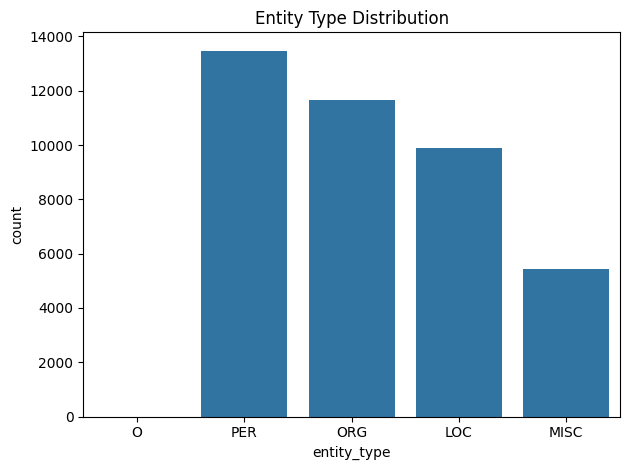

In [15]:
sns.countplot(data=entity_df[entity_df['entity_type'] != 'O'],
              x='entity_type', order=entity_df['entity_type'].value_counts().index)
plt.title('Entity Type Distribution')
plt.tight_layout()
plt.show()

In [16]:
person_df = entity_df[entity_df['entity_type'] == 'PER']

In [17]:
names_by_sentence = defaultdict(list)

current_name = []
current_id = None

for _, row in person_df.iterrows():
    sent_id = row['sentence_id']
    label = row['label']
    token = row['token']

    if label == 'B-PER':
        if current_name:
            names_by_sentence[current_id].append(' '.join(current_name))
        current_name = [token]
        current_id = sent_id
    elif label == 'I-PER' and sent_id == current_id:
        current_name.append(token)
    else:
        if current_name:
            names_by_sentence[current_id].append(' '.join(current_name))
        current_name = []
        current_id = None

if current_name:
    names_by_sentence[current_id].append(' '.join(current_name))

all_person_names = [name for names in names_by_sentence.values()
                    for name in names]

In [18]:
last_names = [HumanName(name).last for name in all_person_names]

df_names = pd.DataFrame({'last': last_names})

In [19]:
ec = EthnicClassifier.load_pretrained_model()

distribution = []

for i in all_person_names:
    nationality = ec.classify_names([i])
    distribution.append(nationality[0])

E:\Software\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
E:\Software\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


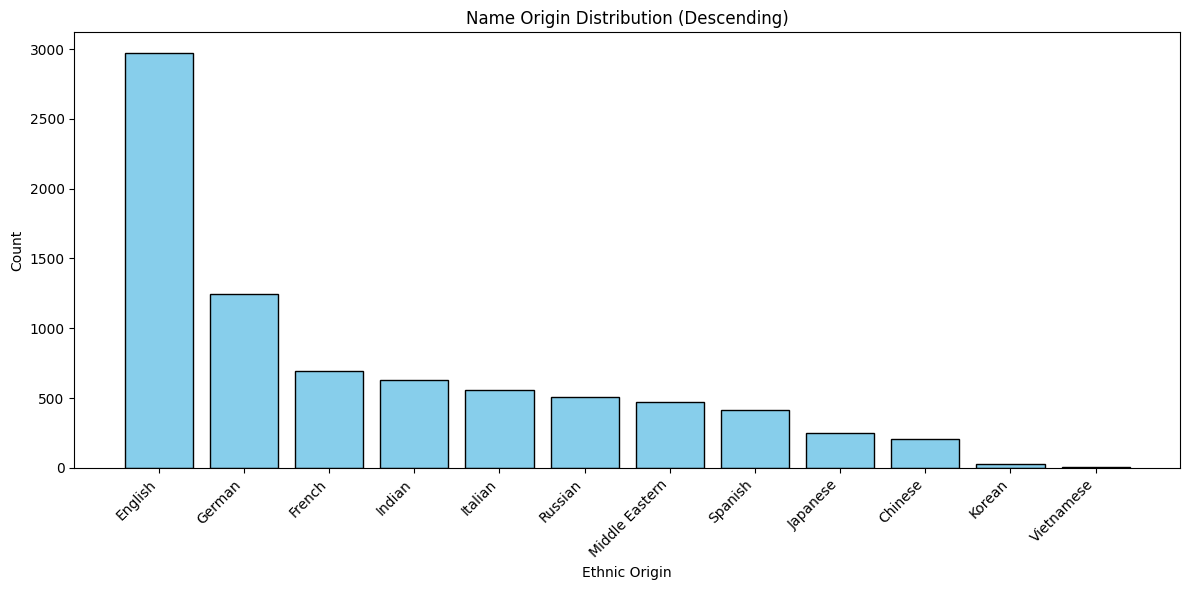

In [20]:


x = Counter(distribution)

full_form = {
    'frn': 'French',
    'ger': 'German',
    'spa': 'Spanish',
    'eng': 'English',
    'chi': 'Chinese',
    'rus': 'Russian',
    'ind': 'Indian',
    'mea': 'Middle Eastern',
    'ita': 'Italian',
    'jap': 'Japanese',
    'kor': 'Korean',
    'vie': 'Vietnamese'
}

sorted_items = sorted(x.items(), key=lambda x: x[1], reverse=True)
labels = [full_form[k] for k, _ in sorted_items]
counts = [v for _, v in sorted_items]

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Name Origin Distribution (Descending)')
plt.xlabel('Ethnic Origin')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [21]:
nd = NameDataset()

In [22]:
gender = []
for i in all_person_names:
    if len(i.split(' ')) > 1:
        a = NameWrapper(nd.search(i.split(' ')[1])).describe[0]
    gender.append(a)

Counter(gender)

Counter({',': 3322, 'M': 3997, 'F': 656})

# Tokenisation & Alignment

In [5]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [75]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_special_tokens_mask=True,
        return_offsets_mapping=True,
    )
    all_word_ids = []
    all_labels = []
    for i, labels in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        all_word_ids.append(word_ids)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    tokenized_inputs["word_ids"] = all_word_ids
    return tokenized_inputs

In [10]:
conll_encoded = conll_main.map(tokenize_and_align_labels, batched=True)
ontonotes_encoded = ontonotes_main.map(
    tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/16595 [00:00<?, ? examples/s]

Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

In [11]:
conll_encoded.save_to_disk("./splits/conll_encoded")
ontonotes_encoded.save_to_disk("./splits/ontonotes_encoded")

Saving the dataset (0/1 shards):   0%|          | 0/16595 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/61371 [00:00<?, ? examples/s]

In [7]:
conll_encoded = load_from_disk("./splits/conll_encoded")
ontonotes_encoded = load_from_disk("./splits/ontonotes_encoded")

In [90]:
def process_data(data_list):

    def process_single(data):
        word_ids = data['word_ids']
        predictions = data['predictions']
        gold = data['gold']
        tokenized_tokens = data['tokens']

        word_ids = [a for a in word_ids if a is not None]
        predictions = [b for a, b in zip(
            word_ids, predictions) if a is not None]
        gold = [b for a, b in zip(word_ids, gold) if a is not None]

        processed_predictions = []
        processed_gold = []

        current_word_id = None
        current_predictions = []
        current_gold = []

        for idx, word_id in enumerate(word_ids):
            if word_id != current_word_id:
                if current_predictions:
                    processed_predictions.append(
                        Counter(current_predictions).most_common(1)[0][0])
                    processed_gold.append(
                        Counter(current_gold).most_common(1)[0][0])

                current_word_id = word_id
                current_predictions = [predictions[idx]]
                current_gold = [gold[idx]]
            else:
                current_predictions.append(predictions[idx])
                current_gold.append(gold[idx])

        if current_predictions:
            processed_predictions.append(
                Counter(current_predictions).most_common(1)[0][0])
            processed_gold.append(
                Counter(current_gold).most_common(1)[0][0])

        return processed_predictions, processed_gold

    processed_predictions_list = []
    processed_gold_list = []

    for data in data_list:
        processed_predictions, processed_gold = process_single(data)
        processed_predictions_list.append(processed_predictions)
        processed_gold_list.append(processed_gold)

    return processed_predictions_list, processed_gold_list


def evaluate_predictions(p, test_data):
    predictions, labels, _ = p

    pred_indices = [np.argmax(p, axis=-1) for p in predictions]
    label_indices = labels

    pred_tags = [[id2label[p] for p, l in zip(p_seq, l_seq) if l != -100]
                 for p_seq, l_seq in zip(pred_indices, label_indices)]
    gold_tags = [[id2label[l] for l in l_seq if l != -100]
                 for l_seq in label_indices]

    def add_preds(example, idx):
        length = len(example['word_ids'])
        example['predictions'] = pred_tags[idx][:length]
        example['gold'] = gold_tags[idx][:length]
        return example

    test_data = test_data.map(add_preds, with_indices=True)

    print(test_data['predictions'][0])
    print(test_data['gold'][0])
    print(test_data['word_ids'][0])

    pred, gold = process_data(test_data)

    flat_pred = [label for seq in pred for label in seq]
    flat_gold = [label for seq in gold for label in seq]

    print(classification_report(flat_gold, flat_pred, zero_division=0))

    return (pred, gold)

# Model

In [59]:
metric = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_predictions.append(
            [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
        true_labels.append([id2label[l] for l in label_seq if l != -100])

    return metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)

In [10]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## ConLL Trained mode

### Initialisation

In [61]:
conll_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(conll_label_to_id)
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Arguments

In [62]:
conll_args = TrainingArguments(
    output_dir="./results/conll",
    eval_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
    logging_steps=1000,
    save_strategy="no",
)

In [63]:
conll_trainer = Trainer(
    model=conll_model,
    args=conll_args,
    train_dataset=conll_encoded,
    eval_dataset=ontonotes_encoded,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_6052\2981314840.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  conll_trainer = Trainer(


In [22]:
conll_trainer.train()


KeyboardInterrupt



### Save + Reload

In [ ]:
conll_trainer.save_model("./saved_model/conll")

In [11]:
model = AutoModelForTokenClassification.from_pretrained("./saved_model/conll")
tokenizer = AutoTokenizer.from_pretrained(model_name)

id2label = {
    0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG",
    5: "B-LOC", 6: "I-LOC", 7: "B-MISC", 8: "I-MISC"
}

metric = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_predictions.append(
            [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
        true_labels.append([id2label[l] for l in label_seq if l != -100])

    return metric.compute(predictions=true_predictions, references=true_labels)


conll_args = TrainingArguments(output_dir="./results/conll",
                               per_device_eval_batch_size=8, report_to="none")

conll_trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    args=conll_args,
)

C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_6052\2299035332.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  conll_trainer = Trainer(


In [ ]:
conll_trainer.evaluate(ontonotes_encoded)

In [12]:
base_conll = conll_trainer.predict(ontonotes_encoded)

In [13]:
with open('./results/base_conll.pkl', 'wb') as f:
    pickle.dump(base_conll, f)

In [10]:
with open('./results/base_conll.pkl', 'rb') as f:
    base_conll = pickle.load(f)

In [23]:
x, y = evaluate_predictions(base_conll, ontonotes_encoded)

              precision    recall  f1-score   support

       B-LOC       0.81      0.89      0.85     18365
      B-MISC       0.61      0.68      0.64     10722
       B-ORG       0.62      0.68      0.65     15004
       B-PER       0.89      0.91      0.90     16696
       I-LOC       0.68      0.55      0.61      4732
      I-MISC       0.61      0.23      0.34      6651
       I-ORG       0.87      0.60      0.71     16775
       I-PER       0.95      0.87      0.91     11710
           O       0.98      0.99      0.99    917439

    accuracy                           0.97   1018094
   macro avg       0.78      0.71      0.73   1018094
weighted avg       0.96      0.97      0.96   1018094



## OntoNotes Trained Mode

### Initialisation

In [ ]:
onto_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(conll_label_to_id)
)

### Arguments

In [ ]:
onto_args = TrainingArguments(
    output_dir="./results/onto",
    eval_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
    logging_steps=1000,
    save_strategy="no",
)

In [ ]:
ontoTrainer = Trainer(
    model=onto_model,
    args=onto_args,
    train_dataset=ontonotes_encoded,
    eval_dataset=conll_encoded,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
ontoTrainer.train()

### Save + Reload

In [ ]:
ontoTrainer.save_model("./saved_model/onto")

In [12]:
onto_model = AutoModelForTokenClassification.from_pretrained(
    "./saved_model/onto")

id2label = {
    0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG",
    5: "B-LOC", 6: "I-LOC", 7: "B-MISC", 8: "I-MISC"
}

metric = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_predictions.append(
            [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
        true_labels.append([id2label[l] for l in label_seq if l != -100])

    return metric.compute(predictions=true_predictions, references=true_labels)


args = TrainingArguments(output_dir="./results",
                         per_device_eval_batch_size=8, report_to="none")

ontoTrainer = Trainer(
    model=onto_model,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    args=args,
)

# ontoTrainer.evaluate(conll_encoded)

C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_6052\700945869.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ontoTrainer = Trainer(


In [15]:
base_onto = ontoTrainer.predict(conll_encoded)

In [16]:
with open('./results/base_onto.pkl', 'wb') as f:
    pickle.dump(base_onto, f)

In [20]:
with open('./results/base_onto.pkl', 'rb') as f:
    base_onto = pickle.load(f)

In [24]:
x, y = evaluate_predictions(base_onto, conll_encoded)

              precision    recall  f1-score   support

       B-LOC       0.76      0.90      0.82      8185
      B-MISC       0.76      0.66      0.71      4232
       B-ORG       0.77      0.54      0.63      8622
       B-PER       0.90      0.93      0.92      9095
       I-LOC       0.57      0.77      0.65      1132
      I-MISC       0.41      0.66      0.51      1176
       I-ORG       0.62      0.74      0.68      3663
       I-PER       0.92      0.99      0.95      6197
           O       0.99      0.98      0.98    167073

    accuracy                           0.94    209375
   macro avg       0.74      0.80      0.76    209375
weighted avg       0.95      0.94      0.94    209375



# Challenge dataset

## Stanford

In [ ]:
# df = pd.read_excel("./Guided-Adversarial-Augmentation-main/Guided-Adversarial-Augmentation-main/data/data/conll2003/challenge_set.xlsx")

# df = df.dropna(how="all", axis=1)

# df.to_csv("challenge_set.csv", index=False)

In [31]:
df = pd.read_excel(
    "./Guided-Adversarial-Augmentation-main/Guided-Adversarial-Augmentation-main/data/data/conll2003/challenge_set.xlsx", header=None)

In [32]:
examples = []

i = 0
while i < len(df):
    row = df.iloc[i]
    if str(row[0]).startswith("GUID"):

        guid = str(df.iloc[i][1]).strip()

        try:
            quality = int(str(df.iloc[i+1][1]).strip())
        except (ValueError, TypeError):
            quality = 999

        try:
            aug_type = int(str(df.iloc[i+2][1]).strip())
        except (ValueError, TypeError):
            aug_type = 999

        tokens_row = df.iloc[i+3].dropna().tolist()[1:]
        labels_row = df.iloc[i+4].dropna().tolist()[1:]
        labels_row = [label.strip()
                      for label in labels_row if label.strip() != ""]

        if len(tokens_row) == len(labels_row):
            examples.append({
                "guid": guid,
                "quality": quality,
                "aug_type": aug_type,
                "tokens": tokens_row,
                "labels": labels_row
            })

        i += 6
    else:
        i += 1

challenge_dataset = Dataset.from_list(examples)

In [33]:
conll_label_to_id = {
    'O': 0,
    'B-PER': 1, 'I-PER': 2,
    'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6,
    'B-MISC': 7, 'I-MISC': 8,
}


def encode_labels(example):
    example["labels"] = [conll_label_to_id.get(
        label, 0) for label in example["labels"]]
    return example

In [34]:
challenge_dataset = challenge_dataset.map(encode_labels)

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

In [35]:
stanford_encoded = challenge_dataset.map(
    tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

In [36]:
stanford_encoded.save_to_disk("./splits/stanford_challenge_encoded")

Saving the dataset (0/1 shards):   0%|          | 0/1418 [00:00<?, ? examples/s]

In [41]:
stanford_encoded = load_from_disk("./splits/stanford_challenge_encoded")

In [ ]:
conll_results = conll_trainer.evaluate(stanford_encoded)
print(conll_results)

In [26]:
predictions_output = conll_trainer.predict(stanford_encoded)

In [27]:
with open('./results/base_stanford.pkl', 'wb') as f:
    pickle.dump(predictions_output, f)

In [25]:
with open('./results/base_stanford.pkl', 'rb') as f:
    base_stanford = pickle.load(f)

In [38]:
x, y = evaluate_predictions(base_stanford, stanford_encoded)

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.58      0.79      0.67       520
      B-MISC       0.93      0.91      0.92       322
       B-ORG       0.67      0.84      0.75      1440
       B-PER       0.84      0.59      0.69      1277
       I-LOC       0.69      0.87      0.77        62
      I-MISC       0.83      0.87      0.85        68
       I-ORG       0.74      0.90      0.81      1831
       I-PER       1.00      0.52      0.68      1231
           O       0.99      0.99      0.99     18158

    accuracy                           0.92     24909
   macro avg       0.81      0.81      0.79     24909
weighted avg       0.93      0.92      0.92     24909



In [ ]:
predicted_label_ids = np.argmax(predictions_output.predictions, axis=2)
true_label_ids = predictions_output.label_ids

id_to_label = {v: k for k, v in conll_label_to_id.items()}

for i in range(len(true_label_ids)):
    tokens = stanford_encoded[i]['tokens']
    true_labels = []
    pred_labels = []

    for j, (true_id, pred_id) in enumerate(zip(true_label_ids[i], predicted_label_ids[i])):
        if true_id != -100:
            true_labels.append(id_to_label[true_id])
            pred_labels.append(id_to_label[pred_id])

    if true_labels != pred_labels:
        print(f"\n--- Sentence {i} ---")
        print("Tokens:       ", tokens)
        print("True Labels:  ", true_labels)
        print("Pred Labels:  ", pred_labels)

In [ ]:
true_tags = []
pred_tags = []

for true_seq, pred_seq in zip(true_label_ids, predicted_label_ids):
    for t, p in zip(true_seq, pred_seq):
        if t != -100:
            true_tags.append(id_to_label[t])
            pred_tags.append(id_to_label[p])

unique_tags = sorted(set(true_tags + pred_tags))
cm = confusion_matrix(true_tags, pred_tags, labels=unique_tags)
for i in unique_tags:
    o_index = unique_tags.index(i)
    cm[o_index, o_index] = 0
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=unique_tags)
disp.plot()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
Onto_results = ontoTrainer.evaluate(stanford_encoded)
print(Onto_results)

In [28]:
onto_predictions_output = ontoTrainer.predict(stanford_encoded)

In [29]:
with open('./results/base_stanford_onto.pkl', 'wb') as f:
    pickle.dump(onto_predictions_output, f)

In [39]:
with open('./results/base_stanford_onto.pkl', 'rb') as f:
    base_stanford_onto = pickle.load(f)

In [50]:
x, y = evaluate_predictions(base_stanford_onto, stanford_encoded)

{'guid': 'test-2', 'quality': 1, 'aug_type': 1, 'tokens': ['AL-AIN', 'Rugby', 'Union', ',', 'United', 'Arab', 'Emirates', '1996-12-06', '^'], 'labels': [-100, 3, 3, 3, 4, 4, 0, 5, 6, 6, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], 'input_ids': [1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Personal

In [ ]:
def get_common_nouns():
    noun_set = set()
    for synset in wn.all_synsets('n'):
        for lemma in synset.lemmas():
            word = lemma.name().replace("_", " ")
            if word.islower() and word.isalpha():
                noun_set.add(word)
    return sorted(noun_set)


common_nouns = get_common_nouns()
print(f"Found {len(common_nouns)} common English nouns.")

In [55]:

sentence_templates = [
    "My name is {name}.",
    "This is {name}, our new team member.",
    "Have you met {name} from the accounting department?",
    "Everyone was waiting for {name} to arrive.",
    "Can you schedule a meeting with {name} next week?",
    "Do you remember when {name} joined the company?",
    "Isn't {name} presenting at the conference?",
    "What did {name} say about the proposal yesterday?",
    "{name}, the regional director, approved the budget.",
    "The person you spoke to earlier, {name}, will send the report.",
    "I met {name} and {name2} at the workshop in Jakarta.",
    "{name} said that {name2} might be late due to traffic.",
    "During yesterday's meeting, {name} brought up an interesting point.",
    "After the interview, we offered {name} the position.",
    "Although {name} was nervous, she performed well.",
    "At the annual summit in Kuala Lumpur, {name} gave a keynote speech.",
    "It was {name} who finalized the agreement.",
    "The report, as mentioned by {name} (our new data analyst), needs a revision.",
    "The final report was prepared by {name}.",
    "Nobody expected {name} to handle the crisis so well.",
    "The consultant who was hired by{name} recommended a new tool.",
    "The woman seen talking to {name} was the CEO.",
    "{name} and his colleague {name2} handled the presentation together.",
    "Both {name} and {name2} have extensive experience in logistics.",
    "{name} introduced {name2} as the lead consultant on the project.",
    "{name}, the new project manager, presented the budget.",
    "While the proposal was being finalized by the marketing team, {name}, who had just returned from Singapore, raised an objection.",
]

In [52]:
nd = NameDataset()
country_codes = nd.get_country_codes()

continent_names = {
    'AF': 'Africa',
    'NA': 'North America',
    'OC': 'Oceania',
    'AN': 'Antarctica',
    'AS': 'Asia',
    'EU': 'Europe',
    'SA': 'South America',
}

continent_to_code = defaultdict(list)

continent_to_countries = defaultdict(list)

for code in country_codes:
    try:
        alpha_2 = code.alpha_2
        country = pycountry.countries.get(alpha_2=alpha_2)
        if not country:
            continue

        continent_code = pc.country_alpha2_to_continent_code(alpha_2)
        continent = continent_names[continent_code]

        continent_to_code[continent].append(alpha_2)
        continent_to_countries[continent].append((alpha_2, country.name))

    except Exception as e:
        print(f"Skipping {code} due to error: {e}")
        continue

continent_to_code

In [53]:
def get_names(country, n=10):
    names_dict = nd.get_top_names(n=n, country_alpha2=country)
    names = []
    if country in names_dict:
        country_names = names_dict[country]
        for gender in ['M', 'F']:
            if gender in country_names:
                names.extend(country_names[gender])
    return list(set(names))


def tokenize(text):
    tokens = re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
    return tokens


def tag_tokens(tokens, person_names):
    tags = ["O"] * len(tokens)
    for name in person_names:
        name_tokens = name.split()
        n_len = len(name_tokens)
        for i in range(len(tokens) - n_len + 1):
            if tokens[i:i + n_len] == name_tokens:
                tags[i] = "B-PER"
                for j in range(i + 1, i + n_len):
                    tags[j] = "I-PER"
    return tags


def generate_challenge_dataset(num_samples=300):
    dataset = []

    for _ in range(num_samples):
        country = random.choice(chosen_countries)
        names = get_names(country, n=10)
        if not names:
            continue

        if len(names) == 1:
            name1 = names[0]
            name2 = None
        else:
            name1, name2 = random.sample(names, 2)

        template = random.choice(sentence_templates)

        if "{name2}" in template and name2 is None:
            sentence = template.format(name=name1, name2=name1)
            person_names = [name1]
        elif "{name2}" in template:
            sentence = template.format(name=name1, name2=name2)
            person_names = [name1, name2]
        else:
            sentence = template.format(name=name1)
            person_names = [name1]

        tokens = tokenize(sentence)
        tags = tag_tokens(tokens, person_names)

        dataset.append(list(zip(tokens, tags)))

    return dataset


def save_to_csv(dataset, filepath="non_western_ner_challenge.csv"):
    with open(filepath, mode="w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["sentence_id", "token", "tag"])
        for idx, sentence in enumerate(dataset):
            for token, tag in sentence:
                writer.writerow([idx, token, tag])

In [56]:
for x in list(continent_to_code.keys()):
    print('Working on ', x)
    chosen_countries = continent_to_code[x]
    data = generate_challenge_dataset(num_samples=1000)
    save_to_csv(data, x+'_ner_challenge.csv')
    print(f"Saved {
          len(data)} sentences with non-Western names to {x}_ner_challenge.csv")

Working on  Asia



KeyboardInterrupt



In [91]:
name_data = []


def evaluate_csv(file):
    print('evaluating', file)
    scripted_challenge = pd.read_csv(file)

    examples = []
    for sentence_id, group in scripted_challenge.groupby("sentence_id"):
        tokens = group["token"].tolist()
        tags = group["tag"].tolist()
        examples.append({"tokens": tokens, "ner_tags": tags})

    unique_tags = sorted(set(tag for ex in examples for tag in ex["ner_tags"]))

    for ex in examples:
        ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

    challenge_dataset = Dataset.from_list(examples)
    tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)

    a = conll_trainer.predict(tokenized)

    with open(f'./results/challenge_{file[:-3]}.pkl', 'wb') as f:
        pickle.dump(a, f)

    x, y = evaluate_predictions(a, tokenized)
    print()
    print('-'*30)

    # a['eval_PER']['name'] = file
    # name_data.append(a['eval_PER'])
    # print(a['eval_PER'])
    # print()

In [92]:
for x in list(continent_to_code.keys()):
    evaluate_csv(x+'_ner_challenge.csv')
    break

evaluating Asia_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

['I-PER', 'I-PER', 'B-PER', 'B-PER', 'B-PER', 'B-PER', 'B-PER', 'B-PER', 'I-PER']
['O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']
[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
      B-MISC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.11      0.59      0.18      1134
       I-LOC       0.00      0.00      0.00         0
      I-MISC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
       I-PER       0.00      0.00      0.00         6
           O       0.73      0.02      0.03      9744

    accuracy                           0.08     10884
   macro avg       0.09      0.07      0.02     10884
weighted avg       0.66      0.08      0.05     10884


--

In [84]:
def evaluate_csv_error(file):
    print('evaluating', file)
    scripted_challenge = pd.read_csv(file)

    examples = []
    for sentence_id, group in scripted_challenge.groupby("sentence_id"):
        tokens = group["token"].tolist()
        tags = group["tag"].tolist()
        examples.append({"tokens": tokens, "ner_tags": tags})

    for ex in examples:
        ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

    challenge_dataset = Dataset.from_list(examples)
    tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)

    # Get model predictions
    outputs = conll_trainer.predict(tokenized)
    predictions = outputs.predictions.argmax(-1)
    true_labels = outputs.label_ids

    # Error analysis
    for i, example in enumerate(examples):
        tokens = example['tokens']
        expected_tags = example['ner_tags']
        predicted_ids = predictions[i]
        true_ids = true_labels[i]

        predicted_tags = [id2label[id_] for id_, true_id in zip(
            predicted_ids, true_ids) if true_id != -100]
        expected_tags_clean = [id2label[true_id]
                               for true_id in true_ids if true_id != -100]
        tokens_clean = [t for t, true_id in zip(
            tokens, true_ids) if true_id != -100]

        for token, expected, predicted in zip(tokens_clean, expected_tags_clean, predicted_tags):
            if expected != predicted:
                print(f"Word: {token}")
                print(f"Expected tag: {expected}")
                print(f"Predicted tag: {predicted}")
                print(f"Full sentence: {' '.join(tokens)}")
                print("------")

In [85]:
evaluate_csv_error('Oceania_ner_challenge.csv')

evaluating Oceania_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Word: the
Expected tag: O
Predicted tag: B-ORG
Full sentence: After the interview , we offered Krishneel the position .
------
Word: interview
Expected tag: O
Predicted tag: B-LOC
Full sentence: After the interview , we offered Krishneel the position .
------
Word: ,
Expected tag: O
Predicted tag: B-ORG
Full sentence: After the interview , we offered Krishneel the position .
------
Word: we
Expected tag: O
Predicted tag: B-MISC
Full sentence: After the interview , we offered Krishneel the position .
------
Word: offered
Expected tag: O
Predicted tag: I-PER
Full sentence: After the interview , we offered Krishneel the position .
------
Word: yesterday
Expected tag: O
Predicted tag: B-ORG
Full sentence: During yesterday ' s meeting , Krishneel brought up an interesting point .
------
Word: '
Expected tag: O
Predicted tag: I-PER
Full sentence: During yesterday ' s meeting , Krishneel brought up an interesting point .
------
Word: s
Expected tag: O
Predicted tag: B-PER
Full sentence: Durin

In [ ]:
df = pd.DataFrame(name_data)

# Extract region names
df["region"] = df["name"].apply(lambda x: x.split("_ner_challenge")[0])

# Plot settings
metrics = ["precision", "recall", "f1"]
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]
y_limits = {"precision": (0.95, 1.01), "recall": (
    0.8, 1.05), "f1": (0.9, 1.01)}

fig, axs = plt.subplots(3, 1, figsize=(10, 14))

for i, met in enumerate(metrics):
    sns.barplot(data=df, x="region", y=met, ax=axs[i], color=colors[i])
    axs[i].set_title(met.capitalize())
    axs[i].set_ylabel("Score")
    axs[i].set_ylim(y_limits[met])
    axs[i].set_xlabel("Region")
    axs[i].tick_params(axis='x', rotation=45)

    # Add values on top of bars
    for p in axs[i].patches:
        height = p.get_height()
        axs[i].annotate(f'{height:.3f}',
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=10)

fig.suptitle("NER Challenge Metrics by Region", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [ ]:
scripted_challenge = pd.read_csv("non_western_ner_challenge.csv")

examples = []
for sentence_id, group in scripted_challenge.groupby("sentence_id"):
    tokens = group["token"].tolist()
    tags = group["tag"].tolist()
    examples.append({"tokens": tokens, "ner_tags": tags})


for ex in examples:
    ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

In [ ]:
challenge_dataset = Dataset.from_list(examples)
tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)
predictions_output = conll_trainer.predict(tokenized)

In [ ]:
conll_trainer.evaluate(tokenized)

In [ ]:
pred_logits = predictions_output.predictions
true_labels = predictions_output.label_ids

pred_label_ids = np.argmax(pred_logits, axis=2)

id2tag = {i: tag for tag, i in conll_label_to_id.items()}

wrong_sentences = []
for i in range(len(true_labels)):
    gold = true_labels[i]
    pred = pred_label_ids[i]

    gold_filtered = [id2tag[lab] for lab, p in zip(gold, pred) if lab != -100]
    pred_filtered = [id2tag[p] for lab, p in zip(gold, pred) if lab != -100]

    gold_bper_positions = [idx for idx, tag in enumerate(
        gold_filtered) if tag == 'B-PER']
    pred_bper_positions = [idx for idx, tag in enumerate(
        pred_filtered) if tag == 'B-PER']

    # if gold_bper_positions != pred_bper_positions:
    wrong_sentences.append({
        "index": i,
        "tokens": tokenized[i]["tokens"],
        "gold_labels": gold_filtered,
        "pred_labels": pred_filtered,
    })

In [ ]:
for idx, i in enumerate(wrong_sentences):
    print(str(idx+1) + " " + " ".join(i['tokens']))
    print(i['gold_labels'])
    print(i['pred_labels'])
    print()

# Seed Variability

In [35]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

conll_label_to_id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
                     'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label = {v: k for k, v in conll_label_to_id.items()}

conll_encoded = load_from_disk("./splits/conll_encoded")
ontonotes_encoded = load_from_disk("./splits/ontonotes_encoded")

data_collator = DataCollatorForTokenClassification(tokenizer)


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_predictions.append(
            [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
        true_labels.append([id2label[l] for l in label_seq if l != -100])

    return metric.compute(predictions=true_predictions, references=true_labels)

In [35]:
seeds = [42, 106, 812, 2025, 9999]
results = []

with open('./results/seed_var_results.pkl', 'rb') as f:
    results = pickle.load(f)

for seed in seeds:
    set_seed(seed)

    conll_model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(conll_label_to_id)
    )

    conll_args = TrainingArguments(
        output_dir=f"./results/conll_seed_{seed}",
        seed=seed,
        eval_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        report_to="none",
        fp16=True,
        logging_steps=1000,
        save_strategy="no",
    )

    conll_trainer = Trainer(
        model=conll_model,
        args=conll_args,
        train_dataset=conll_encoded,
        eval_dataset=ontonotes_encoded,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    conll_trainer.train()
    conll_trainer.save_model("./saved_model/conll_seed_"+str(seed))

    pred = conll_trainer.predict(ontonotes_encoded)
    eval_result = {'predictions': pred, 'seed': seed}
    results.append(eval_result)
    with open('./results/seed_var_results.pkl', 'wb') as f:
        pickle.dump(results, f)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_21136\1554646117.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  conll_trainer = Trainer(


In [37]:
seeds = [42, 106, 812, 2025, 9999]
results = []

for seed in seeds:
    model = AutoModelForTokenClassification.from_pretrained(
        "./saved_model/conll_seed_"+str(seed))
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    id2label = {
        0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG",
        5: "B-LOC", 6: "I-LOC", 7: "B-MISC", 8: "I-MISC"
    }

    conll_args = TrainingArguments(output_dir="./results/conll_seed_"+str(seed),
                                   per_device_eval_batch_size=8, report_to="none")

    conll_trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics,
        args=conll_args,
    )

    pred = conll_trainer.predict(ontonotes_encoded)
    eval_result = {'predictions': pred, 'seed': seed}
    results.append(eval_result)
    with open('./results/seed_var_results.pkl', 'wb') as f:
        pickle.dump(results, f)

C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_21136\3667013058.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  conll_trainer = Trainer(


In [3]:
with open('./results/seed_var_results.pkl', 'rb') as f:
    seed_res = pickle.load(f)

In [53]:
for i in seed_res:
    print('testing seed number', i['seed'])
    x, y = evaluate_predictions(i['predictions'], ontonotes_encoded)

testing seed number 42


Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.81      0.89      0.85     18365
      B-MISC       0.61      0.68      0.64     10722
       B-ORG       0.61      0.68      0.64     15004
       B-PER       0.88      0.91      0.89     16696
       I-LOC       0.68      0.55      0.61      4732
      I-MISC       0.59      0.25      0.35      6651
       I-ORG       0.87      0.60      0.71     16775
       I-PER       0.94      0.88      0.91     11710
           O       0.98      0.99      0.99    917439

    accuracy                           0.97   1018094
   macro avg       0.78      0.71      0.73   1018094
weighted avg       0.96      0.97      0.96   1018094

testing seed number 106


Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.81      0.89      0.85     18365
      B-MISC       0.59      0.69      0.64     10722
       B-ORG       0.63      0.68      0.65     15004
       B-PER       0.85      0.90      0.88     16696
       I-LOC       0.68      0.55      0.61      4732
      I-MISC       0.60      0.24      0.34      6651
       I-ORG       0.87      0.60      0.71     16775
       I-PER       0.94      0.87      0.91     11710
           O       0.98      0.99      0.99    917439

    accuracy                           0.96   1018094
   macro avg       0.77      0.71      0.73   1018094
weighted avg       0.96      0.96      0.96   1018094

testing seed number 812


Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.82      0.88      0.85     18365
      B-MISC       0.62      0.68      0.65     10722
       B-ORG       0.62      0.68      0.65     15004
       B-PER       0.90      0.89      0.89     16696
       I-LOC       0.68      0.55      0.61      4732
      I-MISC       0.59      0.24      0.34      6651
       I-ORG       0.87      0.60      0.71     16775
       I-PER       0.94      0.87      0.91     11710
           O       0.98      0.99      0.99    917439

    accuracy                           0.97   1018094
   macro avg       0.78      0.71      0.73   1018094
weighted avg       0.96      0.97      0.96   1018094

testing seed number 2025


Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.82      0.88      0.85     18365
      B-MISC       0.60      0.69      0.64     10722
       B-ORG       0.63      0.68      0.65     15004
       B-PER       0.89      0.91      0.90     16696
       I-LOC       0.68      0.55      0.60      4732
      I-MISC       0.60      0.24      0.34      6651
       I-ORG       0.87      0.60      0.71     16775
       I-PER       0.95      0.87      0.91     11710
           O       0.98      0.99      0.99    917439

    accuracy                           0.97   1018094
   macro avg       0.78      0.71      0.73   1018094
weighted avg       0.96      0.97      0.96   1018094

testing seed number 9999


Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.82      0.88      0.85     18365
      B-MISC       0.62      0.68      0.65     10722
       B-ORG       0.62      0.68      0.65     15004
       B-PER       0.89      0.91      0.90     16696
       I-LOC       0.69      0.54      0.60      4732
      I-MISC       0.62      0.23      0.33      6651
       I-ORG       0.87      0.60      0.71     16775
       I-PER       0.95      0.87      0.91     11710
           O       0.98      0.99      0.99    917439

    accuracy                           0.97   1018094
   macro avg       0.78      0.71      0.73   1018094
weighted avg       0.96      0.97      0.96   1018094



In [4]:
seed_var = {}
for i in seed_res:
    predictions, labels, _ = i['predictions']
    flat_pred = [label for seq in predictions for label in seq]
    seed_var[i['seed']] = flat_pred

In [ ]:
reli_data = np.array([list(seed_var.values())[0], list(seed_var.values())[1], list(
    seed_var.values())[2], list(seed_var.values())[3], list(seed_var.values())[4]])

In [ ]:
reli_data.shape

In [6]:
import krippendorff
import numpy as np

alpha = krippendorff.alpha(reliability_data=np.array([list(seed_var.values())[0], list(seed_var.values())[1], list(seed_var.values())[2], list(seed_var.values())[3], list(seed_var.values())[4]]).T,
                           level_of_measurement='nominal')

print(f"Krippendorff’s alpha: {alpha:.4f}")

MemoryError: Unable to allocate 20.4 TiB for an array with shape (5, 14544927, 9, 34316) and data type bool

In [ ]:
for r in results:
    # print(r)
    # print()
    print(f"Seed: {r['seed']}, F1: {r['eval_overall_f1']:.4f}, Accuracy: {r['eval_overall_accuracy']:.4f}, Recall: {
          r['eval_overall_recall']:.4f}, Precision: {r['eval_overall_precision']:.4f}")

In [ ]:

with open("seed_results.json", "w") as f:
    json.dump(results, f, indent=2)

In [ ]:
with open("seed_results.json", "r") as f:
    results = json.load(f)

In [ ]:
for i in results:
    print(i)
    print()

In [ ]:


df = pd.DataFrame(results)
df['seed'] = df['seed'].astype(str)

plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

metrics_to_plot = ['eval_overall_f1',
                   'eval_overall_recall', 'eval_overall_precision']

for met in metrics_to_plot:
    sns.lineplot(x='seed', y=met, data=df, marker='o', label=met)


plt.title("Evaluation Metrics across Random Seeds")
plt.xlabel("Seed")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()